
# Pirámides de Gauss y Laplace
**Profesor:** Javier Ruiz del Solar \\
**Auxiliar:** Patricio Loncomilla \\
Estudiante: *Joaquín Zepeda Valero*

In [ ]:
# El objetivo de esta tarea es:
# 1) Implementar convolucion (usando cython)
# 2) Implementar piramides de Gauss y Laplace
# 3) Implementar reconstruccion de una imagen a partir de las piramides
# 4) Graficar las piramides
# 5) Aplicar filtrado pasa alto con laplaciano de gaussiana, y derivadas de gaussiana
# 6) Comparar las imagenes filtradas con las de la piramide de laplace
#
# Nota: los arreglos (matrices) creados deben ser de tipo np.float32

In [ ]:
# Si se usa colaboratory, esta linea permite subir imagenes a la carpeta del notebook
# Si no funciona en firefox, se puede desactivar el "enhanced protection" en "security shield" a la izquierda del url
from google.colab import files
uploaded = files.upload()

Saving origami_2022.jpg to origami_2022.jpg


In [1]:
# Mostrar archivos en la carpeta del notebook
!ls

corteza_2022.jpg  origami_2022.jpg  techo_falso_2022.jpg
dali_2022.jpg	  sample_data


In [2]:
# Para medir tiempo de ejecucion
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.0 MB/s 


In [3]:
# Extensiones
%load_ext Cython
%load_ext autotime

time: 301 µs (started: 2022-09-03 21:22:30 +00:00)


In [4]:
# Paquetes a ser usados
import numpy as np
import cv2
import cython
import numpy as np
import math
# Este paquete solo se debe usar si se usa colaboratory
from google.colab.patches import cv2_imshow

time: 550 ms (started: 2022-09-03 21:22:30 +00:00)


In [5]:
%%cython
import cython
import numpy as np
cimport numpy as np

# La convolucion debe ser implementada usando cython (solo esta funcion en cython)
#@cython.boundscheck(False)
cpdef np.ndarray[np.float32_t, ndim=2] convolution_cython(np.ndarray[np.float32_t, ndim=2] input, np.ndarray[np.float32_t, ndim=2] mask):
  cdef int rows,cols,m_rows,m_cols
  cdef int i,j,ii,jj
  cdef int nn,mm,m_center_x,m_center_y,m,n
  cdef float sum
  cdef np.ndarray[np.float32_t, ndim=2] output = np.zeros([input.shape[0], input.shape[1]], dtype = np.float32)
  
  # tamano de la imagen
  rows = input.shape[0]
  cols = input.shape[1]

  # tamano de la mascara
  m_rows = mask.shape[0]
  m_cols = mask.shape[1]

  #centros
  m_center_x = m_rows//2
  m_center_y = m_cols//2 

  # Por hacer: implementar convolucion entre "input" y "mask"
  for i in range(rows):
    for j in range(cols): #TENGO QUE REVISAR LOS LIMITES
        for m in range(m_rows):
            mm = m_rows-1-m
            for n in range(m_cols):
                nn = m_cols-1-n

                ii = i + (m - m_center_y) 
                jj = j + (n - m_center_x)
                if( ii >= 0 and ii < rows and jj >= 0 and jj<cols):
                    output[i,j] += input[ii,jj]*mask[mm,nn]

  return output


time: 1.63 s (started: 2022-09-03 21:22:31 +00:00)


In [6]:
# Para esta función es importante recordar que la indexación cambia, se busca que el (0,0)
# se ubique en el centro. Además para normalizar se divide por la suma total de los valores 
# de la matriz no normalizada

# sigma corresponde a la desviación, width el tamano de la mascara
def compute_gauss_mask_2d(sigma, width):
  gmask = np.zeros((width, width), np.float32)
  # Por hacer: implementar calculo de mascara gaussiana 2d pixel a pixel
  centro = width//2
  for row in range(width):
      for col in range(width):
          gmask[row,col] = np.exp(-((row-centro)**2+(col-centro)**2)/(2*sigma**2) )/(2*np.pi*sigma**2)
  
  # Se debe normalizar tras calcularla para que las sumas de los pixeles sea igual a 1
  return gmask/np.sum(gmask)

time: 1.63 ms (started: 2022-09-03 21:22:32 +00:00)


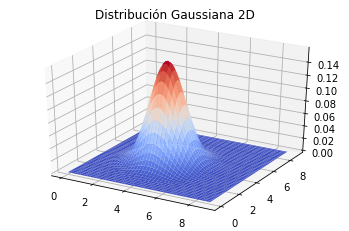

In [7]:
#Prueba 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

sigma = 1
width = 9
gmask = compute_gauss_mask_2d(1, width)
assert int(np.sum(gmask))==1

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, width, 0.1)
X, Y = np.meshgrid(x, y)

def gaussian(row,col,centro,sigma):
    return np.exp(-((row-centro)**2+(col-centro)**2)/(2*sigma**2) )/(2*np.pi*sigma**2)

Z = gaussian(X,Y,width//2,sigma).reshape(X.shape)

ax.plot_surface(X, Y, Z,cmap=cm.coolwarm)
plt.title("Distribución Gaussiana 2D")
plt.show()

time: 370 ms (started: 2022-09-03 21:22:32 +00:00)


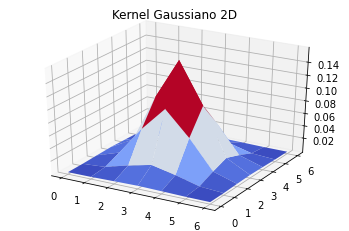

time: 203 ms (started: 2022-09-03 21:22:33 +00:00)


In [8]:
#Prueba 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

sigma = 2
width = 7
gmask = compute_gauss_mask_2d(1, width)
assert int(np.sum(gmask))==1

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, width, 1)
X, Y = np.meshgrid(x, y)

Z = gmask.reshape(X.shape)

ax.plot_surface(X, Y, Z,cmap=cm.coolwarm)
plt.title("Kernel Gaussiano 2D")
plt.show()

In [9]:
def apply_blur(input, sigma, width):
  # Por hacer:
  # 1) Calcular mascara gaussiana 2d con parametros sigma y width
  gmask = compute_gauss_mask_2d(sigma, width)

  # 2) Calcular convolucion entre la imagen de entrada "input" y la mascara 2d
  output = convolution_cython(input, gmask)
  return output

time: 1.16 ms (started: 2022-09-03 21:22:33 +00:00)


In [45]:
def do_subsample(img):
  # por hacer: implementar submuestreo pixel a pixel
  width = img.shape[0]
  heigth  = img.shape[1]
  subsample = np.zeros((int(np.ceil(width/2)), int(np.ceil(heigth/2))), np.float32)
  #print(int(np.ceil(width/2)), int(np.ceil(heigth/2)))
  for i in range(int(np.ceil(width/2))):
      for j in range(int(np.ceil(heigth/2))):
        subsample[i,j] = img[2*i][2*j]
  return subsample

time: 1.69 ms (started: 2022-09-03 21:28:39 +00:00)


In [11]:
originalBGR = cv2.imread('origami_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )
print(input.shape,input)

(367, 653) [[242. 242. 243. ... 244. 244. 244.]
 [243. 243. 243. ... 245. 245. 245.]
 [243. 243. 244. ... 244. 244. 244.]
 ...
 [247. 247. 246. ... 247. 247. 247.]
 [246. 246. 246. ... 247. 247. 247.]
 [238. 237. 237. ... 238. 238. 238.]]
time: 77.5 ms (started: 2022-09-03 21:22:33 +00:00)


# Pausa - Prueba subsample

In [12]:
import cv2
from google.colab.patches import cv2_imshow

time: 896 µs (started: 2022-09-03 21:22:33 +00:00)


(367, 653)


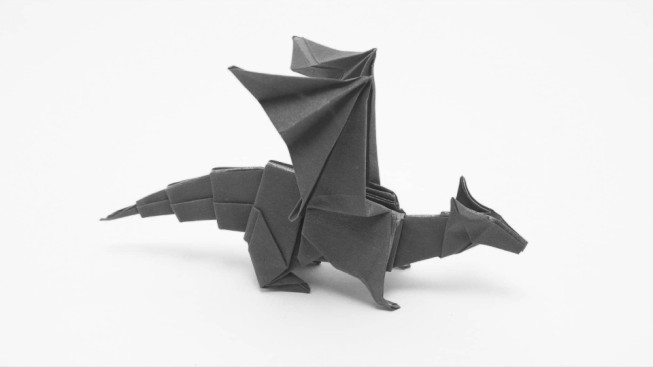

time: 59.9 ms (started: 2022-09-03 21:22:33 +00:00)


In [13]:
originalBGR = cv2.imread('origami_2022.jpg') #Leer imagen

if originalBGR is None:
  assert False, 'Imagen no encontrada'

if len(originalBGR.shape) == 3:
  original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
else:
  original = originalBGR

input = np.float32( original )
print(input.shape)
cv2_imshow(input)

In [14]:
print(input.shape)
a_img = do_subsample(do_subsample(do_subsample(do_subsample(input))))
cv2_imshow(a_img)

(367, 653)
184 327
92 164
46 82
23 41


time: 65.8 ms (started: 2022-09-03 21:22:33 +00:00)


# Continuando

In [15]:
def calc_gauss_pyramid(input, levels):  
  gausspyr = []
  current = np.copy(input)
  gausspyr.append(current)
  for i in range(1,levels):
    # Por hacer:

    # 1) Aplicar apply_blur() a la imagen gausspyr[i-1], con sigma 2.0 y ancho 7
    filtrada = apply_blur(gausspyr[i-1], 2.0 , 7)

    # 2) Submuestrear la imagen resultante usando do_subsample y guardando el resultado en current
    current = do_subsample(filtrada)

    gausspyr.append(current)
  return gausspyr

time: 3.38 ms (started: 2022-09-03 21:22:33 +00:00)


In [16]:
import cv2
from google.colab.patches import cv2_imshow

def show_gauss_pyramid(pyramid):
  # Por hacer: mostrar las imagenes de la piramide de gauss
  # Se recomienda usar cv2_imshow( ) para mostrar las imagenes

  for img in pyramid:
    cv2_imshow(img)


time: 1.42 ms (started: 2022-09-03 21:22:33 +00:00)


In [17]:
def subtract(input1, input2):
  assert input1.shape == input2.shape, print("Problema con tamaños",input1.shape,input2.shape)
  # Por hacer: calcular la resta entre input1 e input2, pixel a pixel
  width = input1.shape[0]
  heigth  = input1.shape[1]
  output = np.zeros((width, heigth), np.float32)
  for i in range(width):
      for j in range(heigth):
          output[i][j] = np.float32(input1[i][j]-input2[i][j])
  return output

time: 2.55 ms (started: 2022-09-03 21:22:33 +00:00)


In [18]:
def add(input1, input2):
  assert input1.shape == input2.shape, print("Problema con tamaños",input1.shape,input2.shape)
  
  # Por hacer: calcular la suma(?) entre input1 e input2, pixel a pixel
  width = input1.shape[0]
  heigth  = input1.shape[1]
  output = np.zeros((width, heigth), np.float32)
  for i in range(width):
      for j in range(heigth):
        output[i][j] = np.float32(input1[i][j]+input2[i][j])
  return output

time: 2.68 ms (started: 2022-09-03 21:22:33 +00:00)


In [19]:
def calc_laplace_pyramid(input, levels):
  gausspyr = []
  laplacepyr = []
  current = np.copy(input)
  gausspyr.append(current)
  for i in range(1, levels):
    # Por hacer:
    # 1) Aplicar apply_blur( ) a la imagen gausspyr[i-1], con sigma 2.0 y ancho 7
    filtrada = apply_blur(gausspyr[i-1],2.0,7)
    # 2) Guardar en laplacepyr el resultado de restar gausspyr[i-1] y la imagen calculada en (1)
    laplacepyr.append(subtract(gausspyr[i-1],filtrada))  # Esta linea se debe reemplazar por lo indicado en (2)
    # 3) Submuestrear la imagen calculada en (1), guardar el resultado en current
    current = do_subsample(filtrada)
    gausspyr.append(current)
  laplacepyr.append(current)  # Se agrega el ultimo piso de la piramide de Laplace
  return laplacepyr

time: 2.69 ms (started: 2022-09-03 21:22:33 +00:00)


In [20]:
def abs_fact(input,factor):
    #  Se debe calcular el valor absoluto de los pixeles, y luego multiplicarlos por un factor
    width = input.shape[0]
    heigth = input.shape[1]
    output = np.zeros((width, heigth), np.float32)
    for i in range(width):
      for j in range(heigth):
        output[i][j] = np.abs(input[i][j])*factor
    return output

time: 2.21 ms (started: 2022-09-03 21:22:33 +00:00)


In [21]:
def show_laplace_pyramid(pyramid):
  # Por hacer: mostrar las imagenes de la piramide de laplace:
  #  Se debe calcular el valor absoluto de los pixeles, y luego multiplicarlos por un factor
  #  Sin embargo, la ultima imagen del ultimo piso se muestra tal cual
  # Se recomienda usar cv2_imshow( ) para mostrar las imagenes

  for i in range(len(pyramid)-1):
    nimg = abs_fact(pyramid[i],factor=5)
    cv2_imshow(nimg)
  cv2_imshow(pyramid[-1])
    

time: 1.55 ms (started: 2022-09-03 21:22:33 +00:00)


In [22]:
def do_upsample(img):
  # Por hacer: implementar duplicacion del tamaño de imagen pixel a pixel
  # Un pixel de la imagen de salida debe ser el promedio de los 4 pixeles mas cercanos de la imagen de entrada
  # Se debe tener cuidado de que los indices no salgan fuera del tamano de la imagen
  width = img.shape[0]
  heigth  = img.shape[1]
  upsample = np.zeros((width*2, heigth*2), np.float32)
  for i in range(width-1):
      for j in range(heigth-1):
        val = np.float32((img[i][j]+img[i+1][j]+img[i][j+1]+img[i+1][j+1])/4)

        upsample[2*i,2*j] = val
        upsample[2*i+1,2*j] = val
        upsample[2*i,2*j+1] = val
        upsample[2*i+1,2*j+1] = val

  return upsample

time: 6.93 ms (started: 2022-09-03 21:22:33 +00:00)


In [23]:
print(input.shape)
print(do_upsample(input).shape)
#cv2_imshow(do_upsample(input))

(367, 653)
(734, 1306)
time: 1.34 s (started: 2022-09-03 21:22:33 +00:00)


In [24]:
def resize(input,x,y):
    if x==input.shape[0] and y==input.shape[1]:
        return input
    output = np.ones((x,y),np.float32)
    #print(input.shape,x,y)
    for i in range(x):
        for j in range(y):
            output[i][j] = input[i][j]
    return output

def do_reconstruct(laplacepyr):
  output = np.copy( laplacepyr[len(laplacepyr)-1] )
  for i in range(1, len(laplacepyr)):
    level = int(len(laplacepyr)) - i - 1
    # Por hacer: repetir estos dos pasos:
    # (1) Duplicar tamano output usando do_upsample( )
    upsample = do_upsample(output)
    #tengo problemas con las dimensiones por lo que voy a agregar un reshape
    #print(upsample.shape)
    upsample = resize(upsample,laplacepyr[level].shape[0],laplacepyr[level].shape[1])
    #print(upsample.shape)
    # (2) Sumar resultado de (1) y laplacepyr[level] usando add( ), almacenar en output
    output = add(upsample, laplacepyr[level])
  return output

time: 2.65 ms (started: 2022-09-03 21:22:35 +00:00)


In [25]:
ls

corteza_2022.jpg  origami_2022.jpg  techo_falso_2022.jpg
dali_2022.jpg     sample_data/
time: 125 ms (started: 2022-09-03 21:22:35 +00:00)


In [26]:
names = ["origami","corteza","dali","techo_falso"]

time: 904 µs (started: 2022-09-03 21:22:35 +00:00)


origami_2022.jpg
Piramide de gauss:
184 327
92 164
46 82
23 41


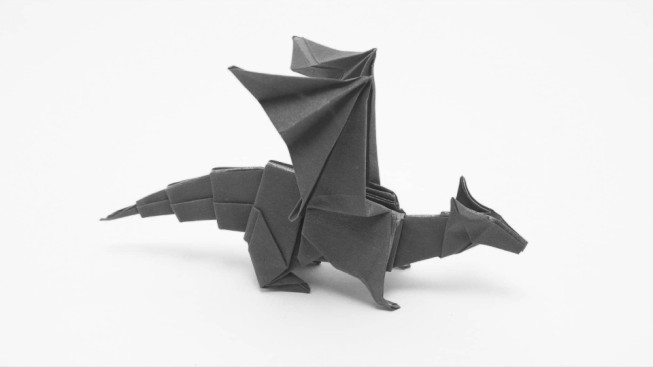

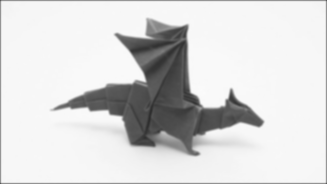

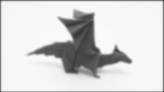

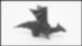

Piramide de laplace:
184 327
92 164
46 82
23 41


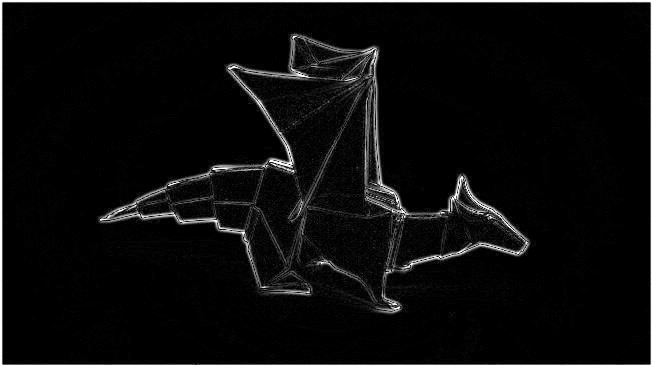

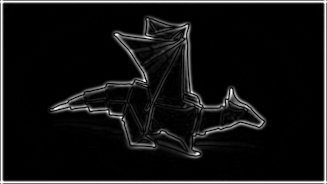

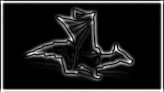

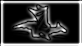

reconstruida:


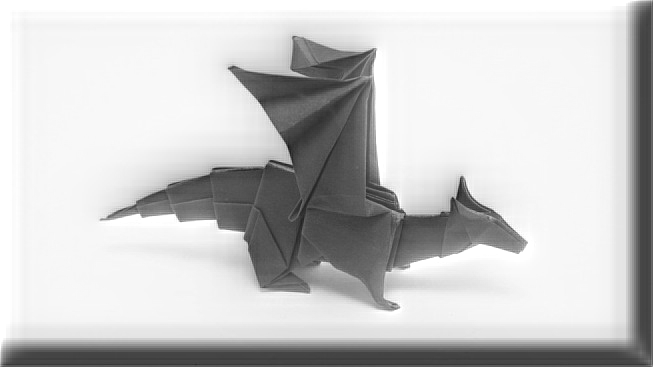

corteza_2022.jpg
Piramide de gauss:
166 249
83 125
42 63
21 32


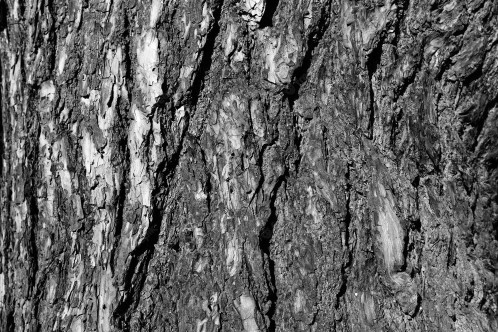

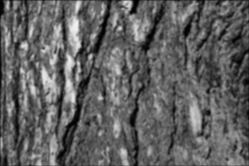

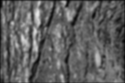

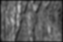

Piramide de laplace:
166 249
83 125
42 63
21 32


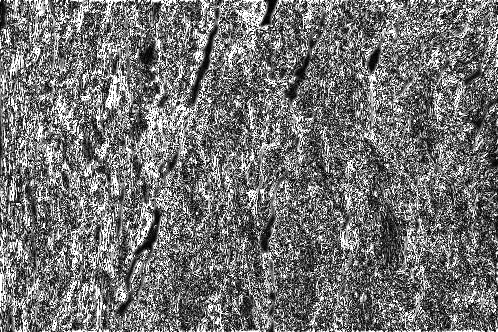

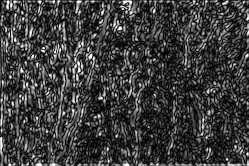

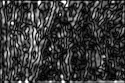

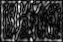

reconstruida:


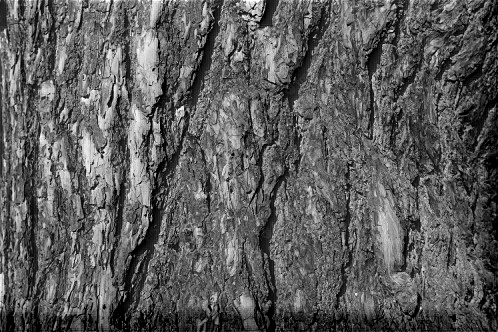

dali_2022.jpg
Piramide de gauss:
175 255
88 128
44 64
22 32


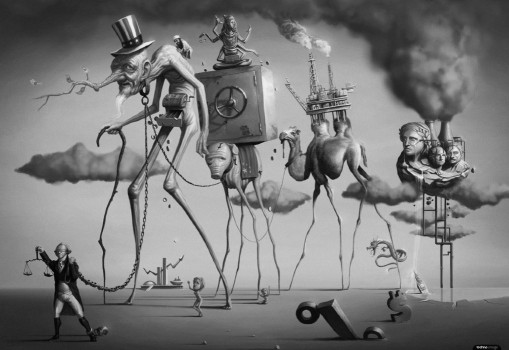

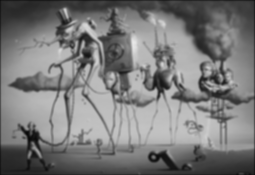

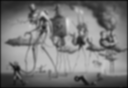

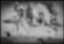

Piramide de laplace:
175 255
88 128
44 64
22 32


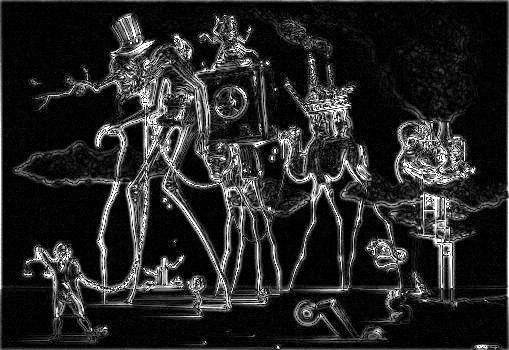

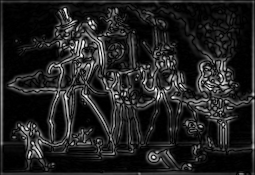

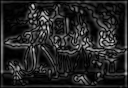

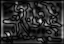

reconstruida:


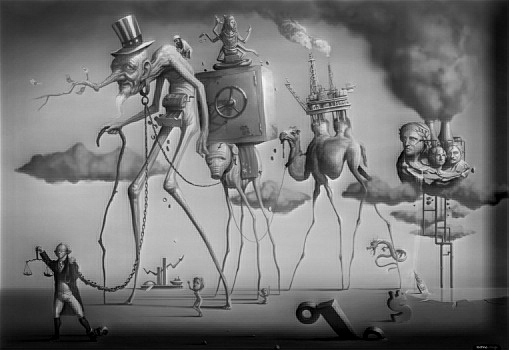

techo_falso_2022.jpg
Piramide de gauss:
176 256
88 128
44 64
22 32


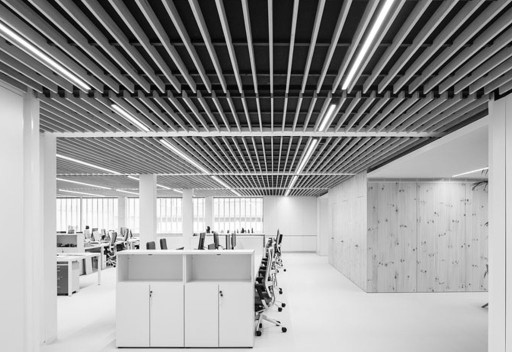

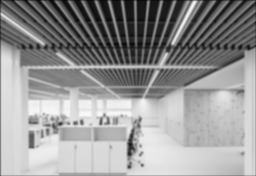

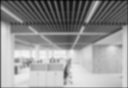

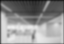

Piramide de laplace:
176 256
88 128
44 64
22 32


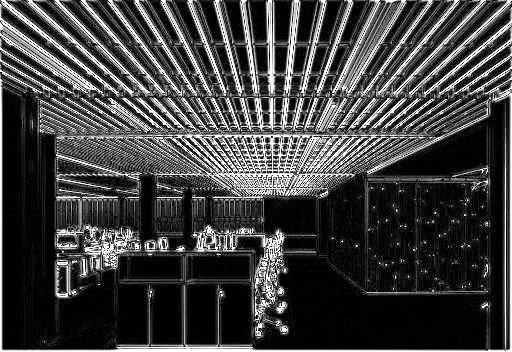

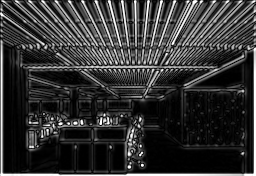

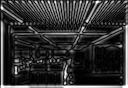

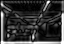

reconstruida:


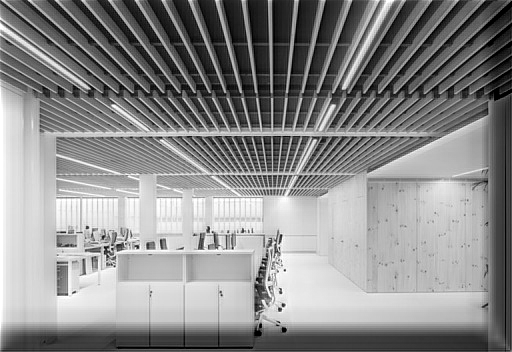

time: 10.5 s (started: 2022-09-03 21:22:35 +00:00)


In [27]:
for nombre in names:
    print(nombre+'_2022.jpg')
    originalBGR = cv2.imread(nombre+'_2022.jpg') #Leer imagen

    if originalBGR is None:
        assert False, 'Imagen no encontrada'

    if len(originalBGR.shape) == 3:
        original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
    else:
        original = originalBGR

    input = np.float32( original )

    print('Piramide de gauss:')
    gausspyramid = calc_gauss_pyramid(input, 5)
    show_gauss_pyramid(gausspyramid)

    print('Piramide de laplace:')
    laplacepyramid = calc_laplace_pyramid(input, 5)
    show_laplace_pyramid(laplacepyramid)

    print('reconstruida:')
    reconstr = do_reconstruct(laplacepyramid)
    cv2_imshow(reconstr)

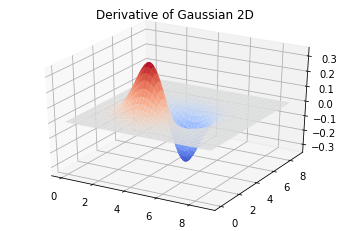

time: 435 ms (started: 2022-09-03 21:22:46 +00:00)


In [28]:
#Prueba 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

sigma = 1
width = 9

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, width, 0.1)
X, Y = np.meshgrid(x, y)

def dgaussian(row,col,centro,sigma):
    return -((row-centro)+(col-centro))*np.exp(-((row-centro)**2+(col-centro)**2)/(2*sigma**2) )/(np.sqrt(2*np.pi)*sigma**3)

Z = dgaussian(X,Y,width//2,sigma).reshape(X.shape)

ax.plot_surface(X, Y, Z,cmap=cm.coolwarm)
plt.title("Derivative of Gaussian 2D")
plt.show()

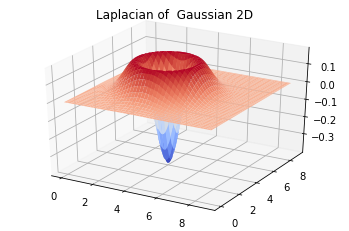

time: 375 ms (started: 2022-09-03 21:22:46 +00:00)


In [29]:
#Prueba 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

sigma = 1
width = 9

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, width, 0.1)
X, Y = np.meshgrid(x, y)

def d2gaussian(row,col,centro,sigma):
    return (-sigma**2+((row-centro)**2+(col-centro)**2) )*np.exp(-((row-centro)**2+(col-centro)**2)/(2*sigma**2) )/(np.sqrt(2*np.pi)*sigma**5)

Z = d2gaussian(X,Y,width//2,sigma).reshape(X.shape)

ax.plot_surface(X, Y, Z,cmap=cm.coolwarm)
plt.title("Laplacian of  Gaussian 2D")
plt.show()

In [30]:
def compute_dgauss_mask_2d(sigma, width,edge):
  gmask = np.zeros((width, width), np.float32)
  # Por hacer: implementar calculo de mascara gaussiana 2d pixel a pixel
  centro = width//2
  for row in range(width):
      for col in range(width):
          if edge=="x":
              val = row
          else:
              val = col
          gmask[row][col] = ((-(val-centro))/(2*np.pi*sigma**4))*np.exp(-((row-centro)**2+(col-centro)**2)/(2*sigma**2) )
  return gmask

def compute_d2gauss_mask_2d(sigma, width,edge):
  gmask = np.zeros((width, width), np.float32)
  # Por hacer: implementar calculo de mascara gaussiana 2d pixel a pixel
  centro = width//2
  for row in range(width):
      for col in range(width):
          if edge=="x":
              val = row
          else:
              val = col
          gmask[row][col] = (-1 + (val-centro)**2/sigma**2)*np.exp(-((row-centro)**2+(col-centro)**2)/(2*sigma**2) )/(2*np.pi*sigma**4)
  return gmask

time: 4.96 ms (started: 2022-09-03 21:22:46 +00:00)


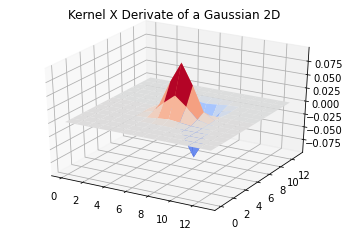

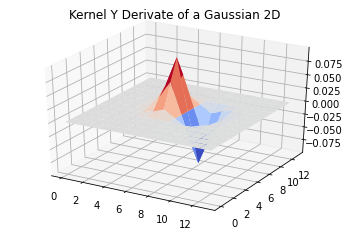

time: 386 ms (started: 2022-09-03 21:22:46 +00:00)


In [31]:
#Prueba 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

sigma = 4
width = 14
gmask_x = compute_dgauss_mask_2d(1, width,'x')
gmask_y = compute_dgauss_mask_2d(1, width,'y')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, width, 1)
X, Y = np.meshgrid(x, y)

Z = gmask_x.reshape(X.shape)

ax.plot_surface(X, Y, Z,cmap=cm.coolwarm)
plt.title("Kernel X Derivate of a Gaussian 2D")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, width, 1)
X, Y = np.meshgrid(x, y)

Z = gmask_y.reshape(X.shape)

ax.plot_surface(X, Y, Z,cmap=cm.coolwarm)
plt.title("Kernel Y Derivate of a Gaussian 2D")
plt.show()

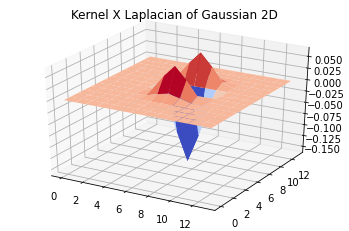

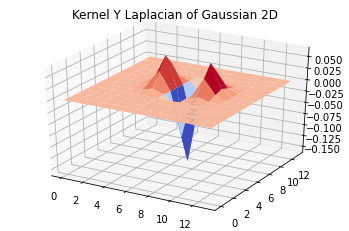

time: 391 ms (started: 2022-09-03 21:22:47 +00:00)


In [32]:
#Prueba 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

sigma = 4
width = 14
gmask_x = compute_d2gauss_mask_2d(1, width,'x')
gmask_y = compute_d2gauss_mask_2d(1, width,'y')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, width, 1)
X, Y = np.meshgrid(x, y)

Z = gmask_x.reshape(X.shape)

ax.plot_surface(X, Y, Z,cmap=cm.coolwarm)
plt.title("Kernel X Laplacian of Gaussian 2D")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, width, 1)
X, Y = np.meshgrid(x, y)

Z = gmask_y.reshape(X.shape)

ax.plot_surface(X, Y, Z,cmap=cm.coolwarm)
plt.title("Kernel Y Laplacian of Gaussian 2D")
plt.show()

In [50]:
def pasa_alto(img,tipo_filtro,sigma,width,factor=5):
    #print(img.shape)
    output = np.zeros((img.shape[0], img.shape[1]), np.float32)
    if tipo_filtro=="1d":
        dgmask_x = compute_dgauss_mask_2d(sigma, width,"x")
        dgmask_y = compute_dgauss_mask_2d(sigma, width,"y")
    else:
        dgmask_x = compute_d2gauss_mask_2d(sigma, width,"x")
        dgmask_y = compute_d2gauss_mask_2d(sigma, width,"y")
    output_x = convolution_cython(img, dgmask_x)
    output_y = convolution_cython(img, dgmask_y)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            #se le agrega un factor solo para mostrar de mejor manera los resultados
            output[x][y] = np.sqrt(output_x[x][y]**2+output_y[x][y]**2)*factor
    return output


time: 3.17 ms (started: 2022-09-03 23:01:57 +00:00)


origami_2022.jpg


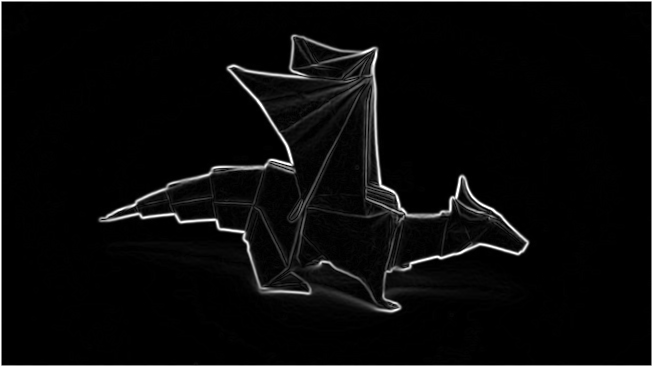

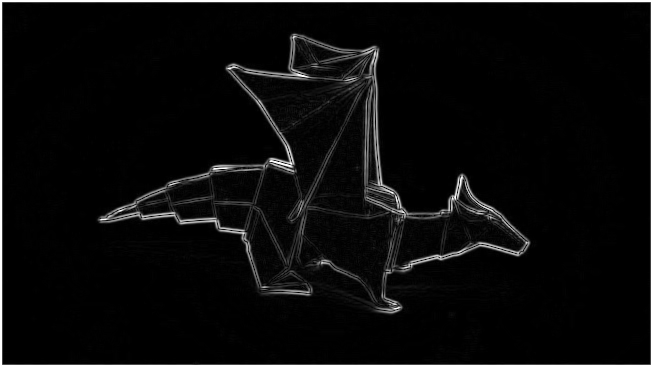

corteza_2022.jpg


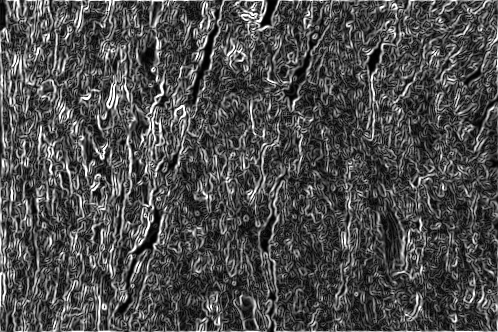

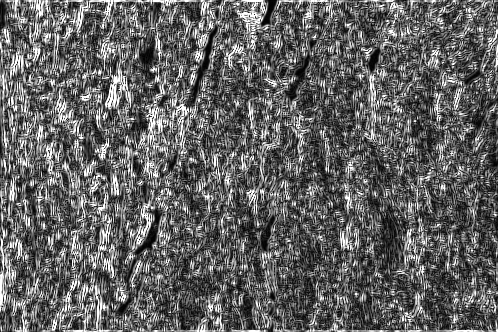

dali_2022.jpg


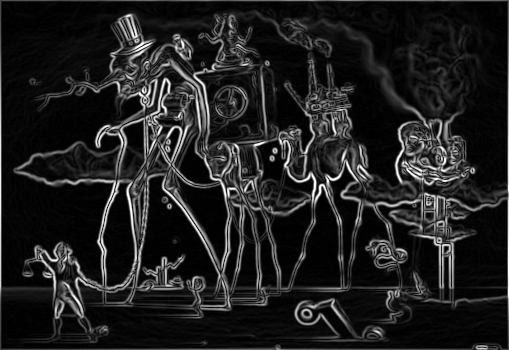

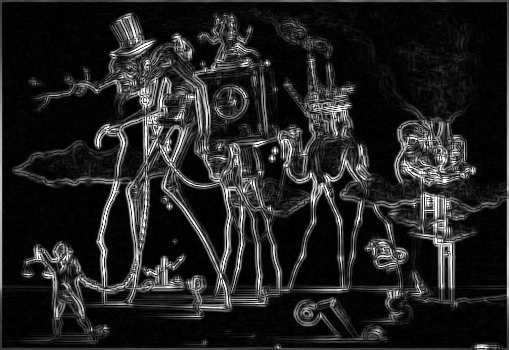

techo_falso_2022.jpg


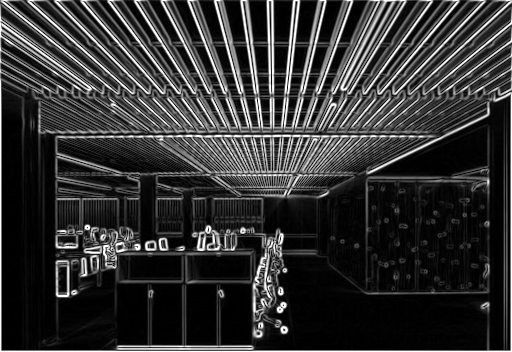

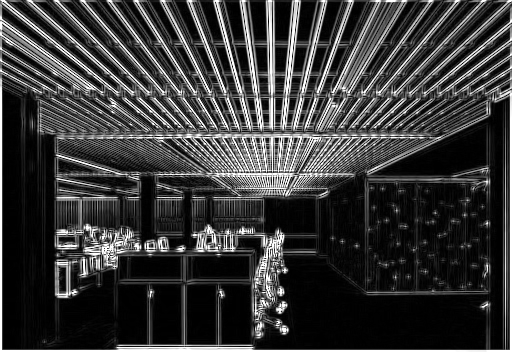

time: 15.6 s (started: 2022-09-04 00:22:45 +00:00)


In [85]:
for nombre in names:
    print(nombre+'_2022.jpg')
    originalBGR = cv2.imread(nombre+'_2022.jpg') #Leer imagen

    if originalBGR is None:
        assert False, 'Imagen no encontrada'

    if len(originalBGR.shape) == 3:
        original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
    else:
        original = originalBGR

    input = np.float32( original )
    cv2_imshow(pasa_alto(input,"1d",1,5))
    cv2_imshow(pasa_alto(input,"2d",1,15,7))

time: 16.7 s (started: 2022-09-03 21:22:47 +00:00)


In [35]:
import cv2
from google.colab.patches import cv2_imshow

def show_gauss_pyramid2(pyramid):
  # Por hacer: mostrar las imagenes de la piramide de gauss
  # Se recomienda usar cv2_imshow( ) para mostrar las imagenes

  for img in pyramid:
    cv2_imshow(pasa_alto(img,"1d",1,15))

time: 2.34 ms (started: 2022-09-03 21:23:04 +00:00)


origami_2022.jpg
Piramide de gauss:


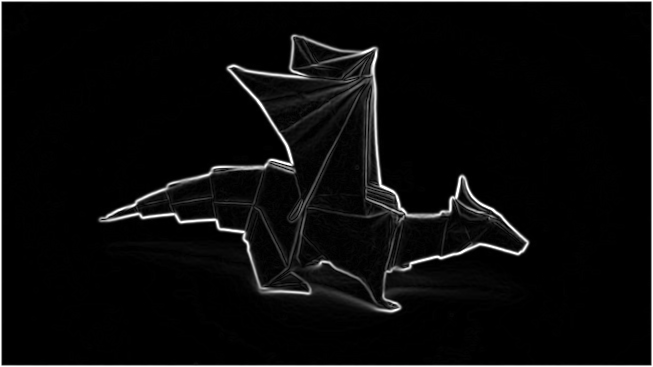

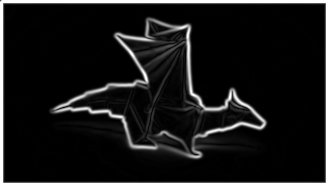

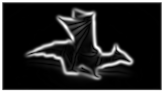

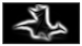

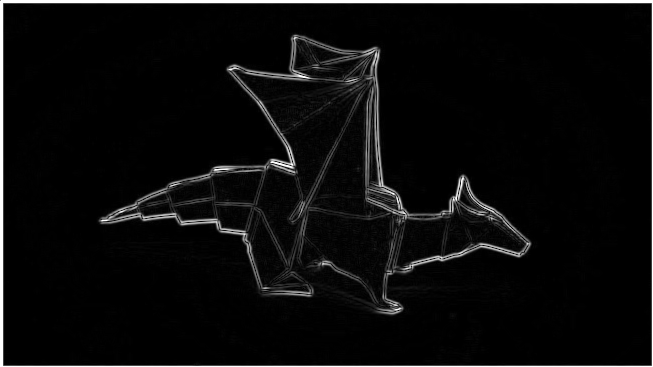

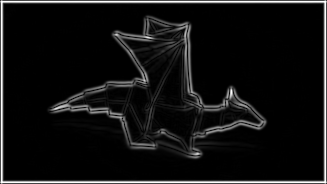

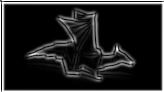

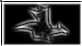

corteza_2022.jpg
Piramide de gauss:


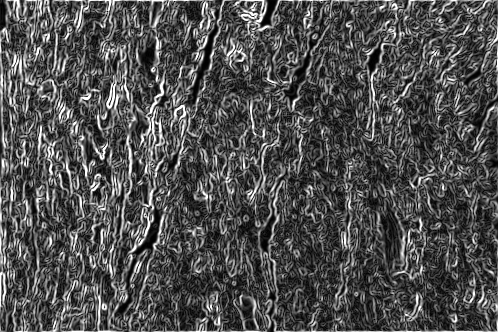

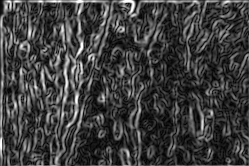

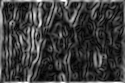

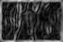

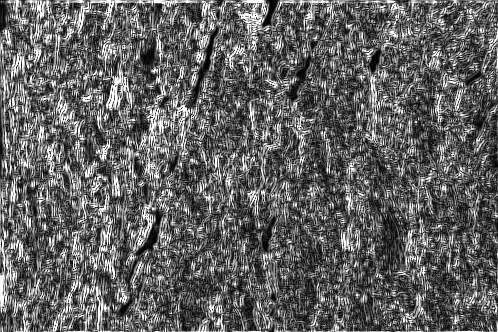

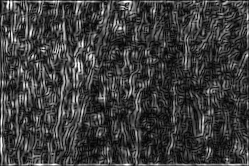

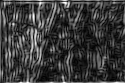

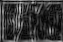

dali_2022.jpg
Piramide de gauss:


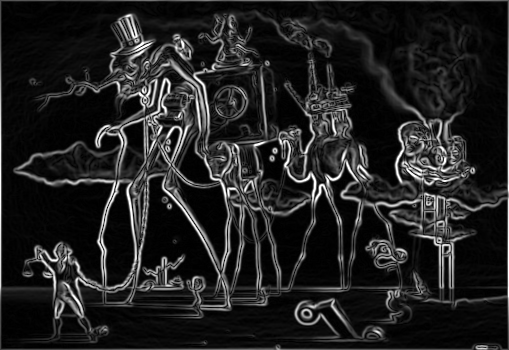

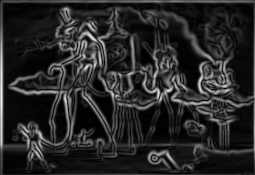

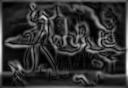

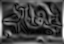

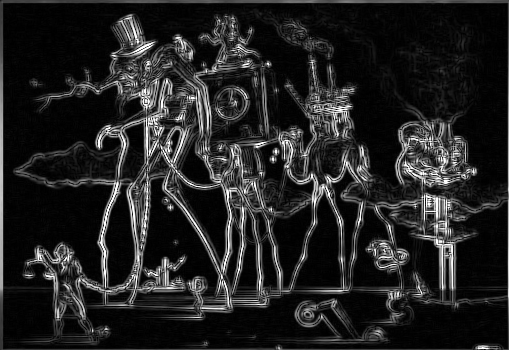

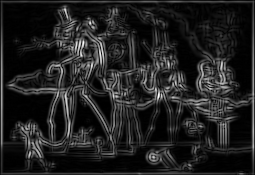

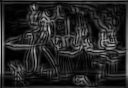

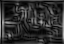

techo_falso_2022.jpg
Piramide de gauss:


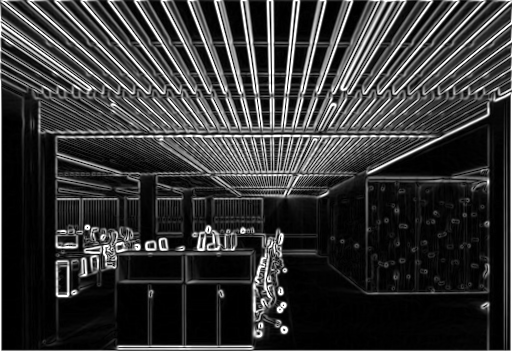

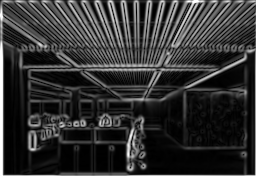

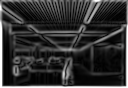

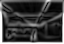

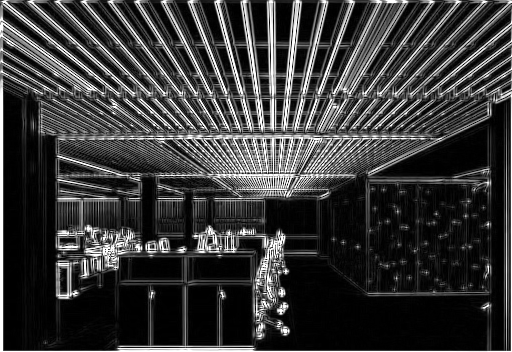

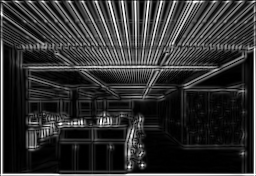

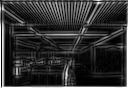

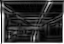

time: 24.3 s (started: 2022-09-03 23:42:49 +00:00)


In [74]:
for nombre in names:
    print(nombre+'_2022.jpg')
    originalBGR = cv2.imread(nombre+'_2022.jpg') #Leer imagen

    if originalBGR is None:
        assert False, 'Imagen no encontrada'

    if len(originalBGR.shape) == 3:
        original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
    else:
        original = originalBGR

    input = np.float32( original )

    print('Piramide de gauss:')
    gausspyramid = calc_gauss_pyramid(input, 5)
    S = [1,1,1,1,1]
    W = [15,12,9,7,5,3]
    for img,width,s in zip(gausspyramid,W,S):
        cv2_imshow(pasa_alto(img,"1d",s,width))
    for img,width in zip(gausspyramid,W):
        cv2_imshow(pasa_alto(img,"2d",s,width+5,7))

origami_2022.jpg
Piramide de gauss:


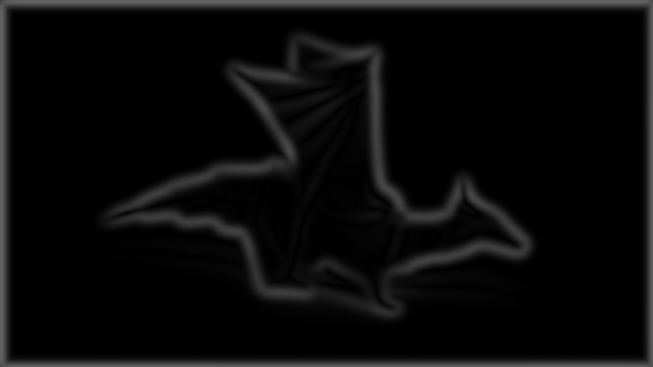

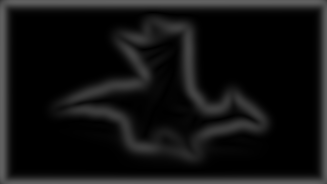

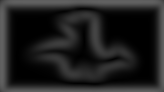

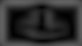

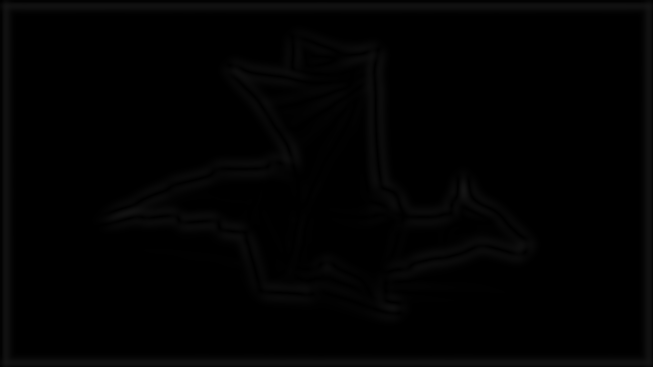

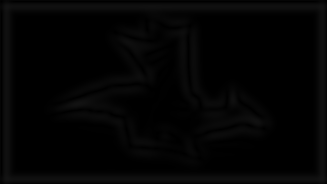

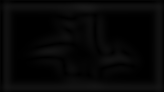

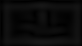

corteza_2022.jpg
Piramide de gauss:


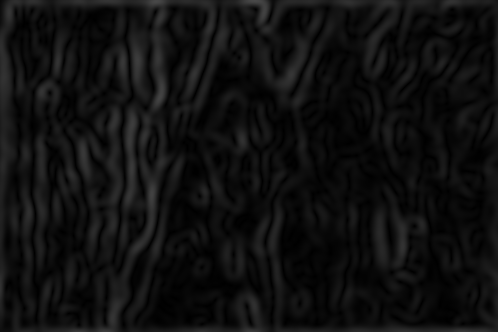

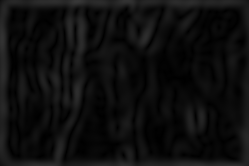

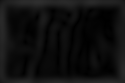

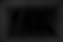

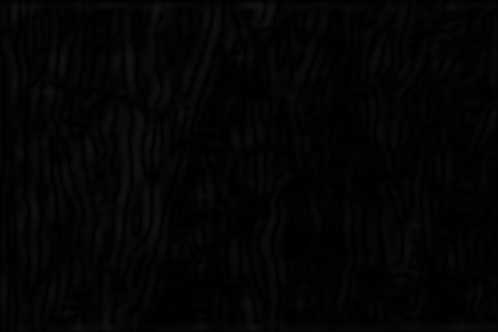

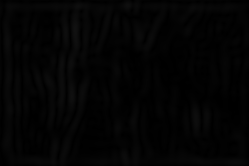

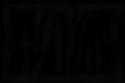

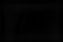

dali_2022.jpg
Piramide de gauss:


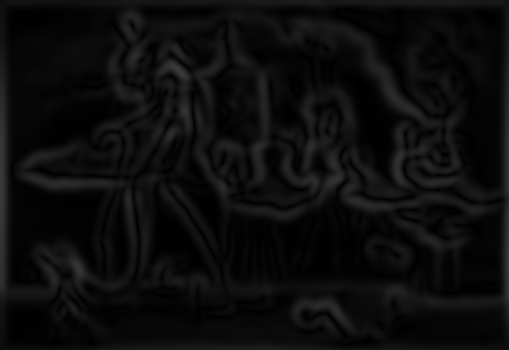

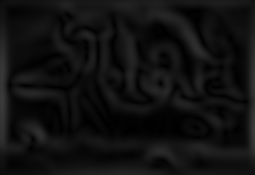

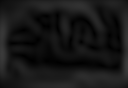

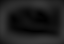

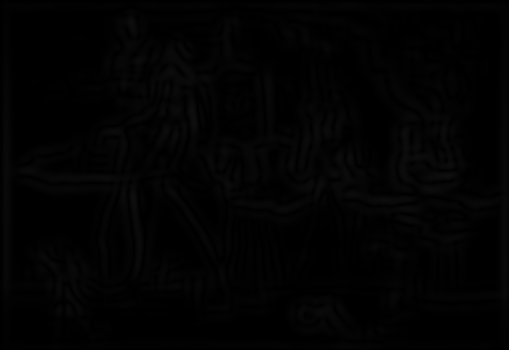

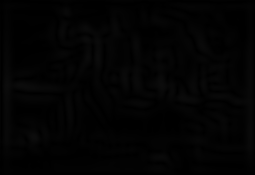

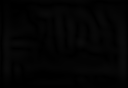

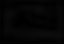

techo_falso_2022.jpg
Piramide de gauss:


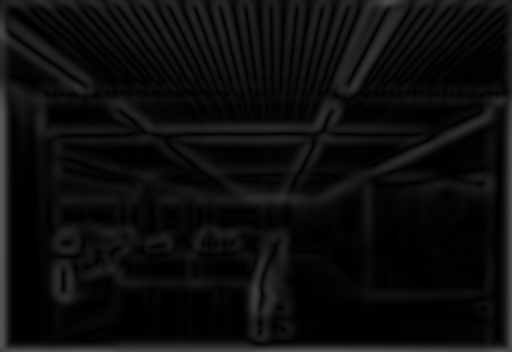

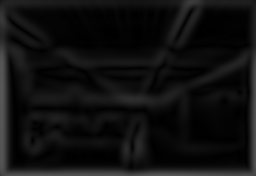

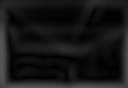

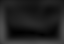

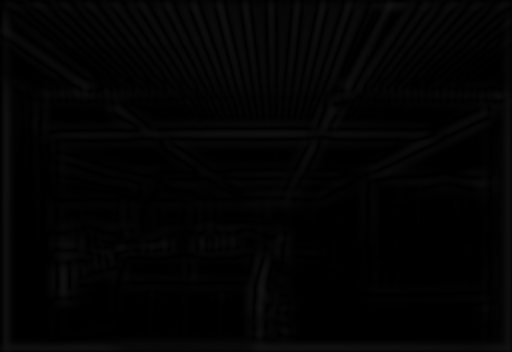

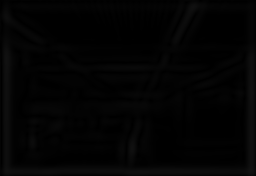

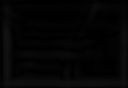

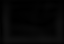

time: 3min 26s (started: 2022-09-04 00:03:54 +00:00)


In [83]:
for nombre in names:
    print(nombre+'_2022.jpg')
    originalBGR = cv2.imread(nombre+'_2022.jpg') #Leer imagen

    if originalBGR is None:
        assert False, 'Imagen no encontrada'

    if len(originalBGR.shape) == 3:
        original = cv2.cvtColor(originalBGR, cv2.COLOR_BGR2GRAY)
    else:
        original = originalBGR

    input = np.float32( original )

    print('Piramide de gauss:')
    gausspyramid = calc_gauss_pyramid(input, 5)
    S = [5]*5
    W = [100]*5
    for img,width,s in zip(gausspyramid,W,S):
        cv2_imshow(pasa_alto(img,"1d",s,width))
    for img,width in zip(gausspyramid,W):
        cv2_imshow(pasa_alto(img,"2d",s,width,7))